In [74]:
####################read dataset#########################
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_folder = "data/img"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio = 0.8

train_files = image_files[:int(total_images * train_ratio)]
test_files = image_files[int(total_images * train_ratio):]
#print(train_files)
#print(test_files)

In [75]:
#Create a vocabulary dictionary that maps all the unique color tokens from your train and test data as keys to a unique integer value.
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
color_unique = item_attr_data['clothes_color'].unique()
print("number of colors:",len(color_unique))
color_vocab = sorted(set(color_unique))
color_vocabulary = {w:i for i, w in enumerate(color_vocab)}
#print(color_vocabulary)
for i,j in enumerate(item_attr_data['clothes_color']):
    color_value = color_vocabulary[j]
    item_attr_data.loc[i, "clothes_color"] = color_value

number of colors: 759


In [76]:
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)
train_labels = train_labels.drop(columns=['index','img_idx'])
train_color = train_labels.pop('clothes_color')

train_color_np = train_color.to_numpy(dtype=np.int32)
train_labels_np = train_labels.to_numpy(dtype=np.float32)
train_labels_np = (train_labels_np + 1) / 2

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)
test_labels = test_labels.drop(columns=['index','img_idx'])
test_color = test_labels.pop('clothes_color')

test_color_np = test_color.to_numpy(dtype=np.int32)
test_labels_np = test_labels.to_numpy(dtype=np.float32)
test_labels_np = (test_labels_np + 1) / 2

# print(train_labels_np[:5])
# print(train_color_np[:5])

In [77]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [78]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [79]:
train_color_ids_dataset = tf.data.Dataset.from_tensor_slices(train_color_np)
test_color_ids_dataset = tf.data.Dataset.from_tensor_slices(test_color_np)

train_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(train_labels_np)
test_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(test_labels_np)

train_dataset = tf.data.Dataset.zip((train_dataset, train_color_ids_dataset, train_binary_attributes_dataset))
test_dataset = tf.data.Dataset.zip((test_dataset, test_color_ids_dataset, test_binary_attributes_dataset))

train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [80]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 463), dtype=tf.float32, name=None))>


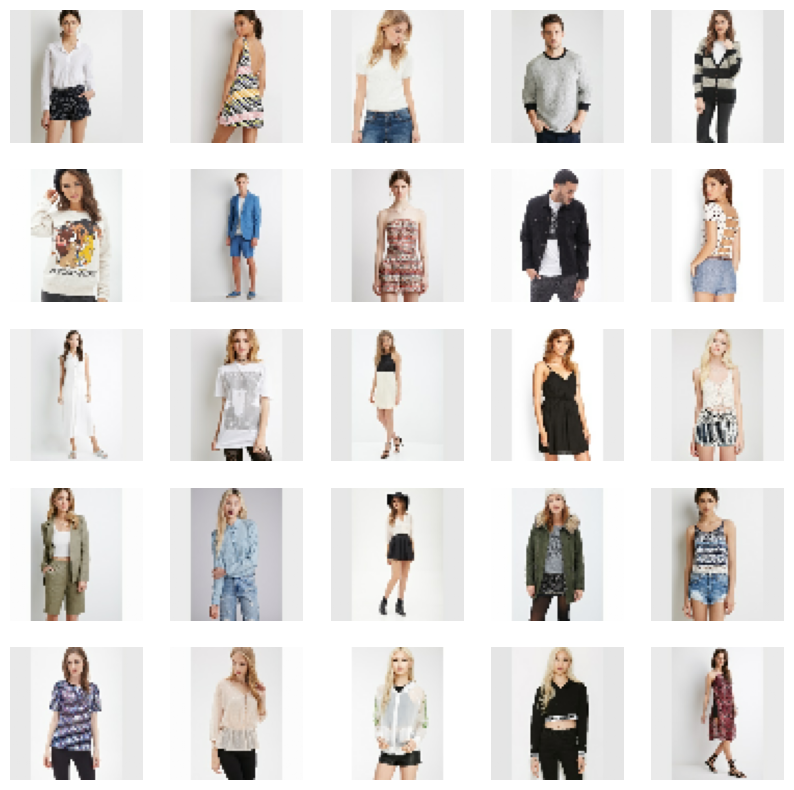

In [81]:
#################show the image####################
# Define a function to display a batch of images
def show_images(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()
    
# Get a batch of images from the train_dataset
for images, color_ids, binary_attributes in train_dataset.take(1):
    show_images(images)

In [154]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K


# Hyperparameters
embedding_dimension = 16
latent_dimension = 256
num_colors = 759
num_binary_attributes = 463
input_shape = (64, 64, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
# def create_encoder(input_shape, num_attributes):
#     inputs = Input(shape=input_shape, name="encoder_input")
#     attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
#     x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     x = layers.Flatten()(x)
#     x = layers.Dense(latent_dimension, activation="relu")(x)
    
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     merged = layers.Concatenate()([x, attr_x])   
    
#     z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
#     z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
#     return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_vgg16_encoder(input_shape, num_attributes):
    inputs = Input(shape=input_shape, name="encoder_input")
    attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
    # Use VGG16 as a feature extractor
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Set VGG16 layers to non-trainable
    for layer in vgg16.layers:
        layer.trainable = False
    
    # Apply VGG16 to the input images
    x = vgg16(inputs)
    
    # Flatten and reduce the dimensionality of the VGG16 features
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
    
    merged = layers.Concatenate()([x, attr_x])
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
    return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")


def create_unet_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")

    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)

    # Encoder part (contracting path)
    e1 = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    e2 = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(e1)

    # Decoder part (expanding path)
    d1 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(e2)
    d1 = layers.Concatenate()([d1, e1])  # Skip connection
    d2 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(d1)
    d2 = layers.Concatenate()([d2, x])  # Skip connection

    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(d2)

    return Model(inputs, outputs, name="decoder")

# # Decoder
# def create_decoder(latent_dimension, num_attributes):
#     inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
#     x = layers.Dense(latent_dimension, activation="relu")(inputs)
#     x = layers.Dense(16 * 16 * 16, activation="relu")(x)
#     x = layers.Reshape((16, 16, 16))(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
#     return Model(inputs, outputs, name="decoder")

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        #attribute_vector = layers.Concatenate(axis=-1)([color_embeds])
        
        # Encode input images and attributes
        z_mean, z_log_var = self.encoder([images, attribute_vector])
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and CVAE model
#encoder = create_encoder(input_shape, embedding_dimension + num_binary_attributes)
# decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)
vgg16_encoder = create_vgg16_encoder(input_shape, embedding_dimension + num_binary_attributes)
unet_decoder = create_unet_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
cvae = CVAE(vgg16_encoder, unet_decoder, color_embedding, num_binary_attributes)
#cvae = CVAE(encoder, unet_decoder, color_embedding, num_binary_attributes)
# encoder = create_encoder(input_shape, embedding_dimension)
# decoder = create_decoder(latent_dimension, embedding_dimension)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    beta = 0.1
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = cvae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(layers.Flatten()(images), layers.Flatten()(reconstructed_images))
        rec_loss *= input_shape[0] * input_shape[1] * input_shape[2]
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + beta * kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    
    return total_loss, rec_loss, kl_loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        total_loss, rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Total loss: {total_loss:.4f}, Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")

Epoch 1/10
Total loss: 1901.5052, Reconstruction loss: 1897.9890, KL loss: 35.1629
Total loss: 1920.6405, Reconstruction loss: 1917.4958, KL loss: 31.4467
Total loss: 1847.7970, Reconstruction loss: 1844.5580, KL loss: 32.3902
Total loss: 1804.9683, Reconstruction loss: 1801.5824, KL loss: 33.8584
Total loss: 1795.3979, Reconstruction loss: 1791.7598, KL loss: 36.3819
Total loss: 1736.9784, Reconstruction loss: 1733.0483, KL loss: 39.3006
Total loss: 1715.9994, Reconstruction loss: 1711.7209, KL loss: 42.7849
Total loss: 1633.4143, Reconstruction loss: 1628.7703, KL loss: 46.4401
Total loss: 1556.2789, Reconstruction loss: 1551.2297, KL loss: 50.4915
Total loss: 1516.4645, Reconstruction loss: 1510.9171, KL loss: 55.4736
Total loss: 1451.4048, Reconstruction loss: 1445.4119, KL loss: 59.9298
Total loss: 1363.7916, Reconstruction loss: 1357.3020, KL loss: 64.8960
Total loss: 1264.3486, Reconstruction loss: 1257.1753, KL loss: 71.7340
Total loss: 1163.8137, Reconstruction loss: 1155.8951

Total loss: 462.3347, Reconstruction loss: 452.3341, KL loss: 100.0051
Total loss: 453.2215, Reconstruction loss: 443.2636, KL loss: 99.5792
Total loss: 471.4886, Reconstruction loss: 461.5693, KL loss: 99.1928
Total loss: 478.4022, Reconstruction loss: 468.5221, KL loss: 98.8012
Total loss: 456.2389, Reconstruction loss: 446.4000, KL loss: 98.3889
Total loss: 464.8988, Reconstruction loss: 455.1274, KL loss: 97.7144
Total loss: 471.8960, Reconstruction loss: 462.1878, KL loss: 97.0818
Total loss: 441.4454, Reconstruction loss: 431.7836, KL loss: 96.6179
Total loss: 432.2937, Reconstruction loss: 422.5838, KL loss: 97.0987
Total loss: 460.6472, Reconstruction loss: 451.1149, KL loss: 95.3235
Total loss: 490.4723, Reconstruction loss: 480.8638, KL loss: 96.0852
Total loss: 449.9715, Reconstruction loss: 440.6445, KL loss: 93.2692
Total loss: 491.6816, Reconstruction loss: 482.4942, KL loss: 91.8740
Epoch 3/10
Total loss: 427.9046, Reconstruction loss: 418.6453, KL loss: 92.5931
Total lo

Total loss: 380.0735, Reconstruction loss: 375.1214, KL loss: 49.5210
Total loss: 385.8764, Reconstruction loss: 380.8705, KL loss: 50.0597
Total loss: 404.6237, Reconstruction loss: 399.7717, KL loss: 48.5202
Total loss: 388.7719, Reconstruction loss: 383.7728, KL loss: 49.9907
Total loss: 419.5628, Reconstruction loss: 414.7454, KL loss: 48.1741
Total loss: 375.8813, Reconstruction loss: 371.0349, KL loss: 48.4641
Total loss: 431.6344, Reconstruction loss: 426.7046, KL loss: 49.2981
Total loss: 410.5209, Reconstruction loss: 405.6761, KL loss: 48.4475
Total loss: 424.8051, Reconstruction loss: 419.9351, KL loss: 48.6998
Total loss: 398.2343, Reconstruction loss: 393.3972, KL loss: 48.3712
Total loss: 383.6522, Reconstruction loss: 378.7763, KL loss: 48.7590
Total loss: 402.2800, Reconstruction loss: 397.6096, KL loss: 46.7042
Total loss: 388.4290, Reconstruction loss: 383.7216, KL loss: 47.0742
Total loss: 399.0983, Reconstruction loss: 394.0427, KL loss: 50.5564
Total loss: 401.9731

Total loss: 378.8296, Reconstruction loss: 371.8804, KL loss: 69.4915
Total loss: 354.0935, Reconstruction loss: 346.9820, KL loss: 71.1154
Total loss: 354.3883, Reconstruction loss: 347.3499, KL loss: 70.3846
Total loss: 355.6516, Reconstruction loss: 348.5795, KL loss: 70.7202
Total loss: 396.9882, Reconstruction loss: 389.9183, KL loss: 70.6982
Total loss: 344.6580, Reconstruction loss: 337.6898, KL loss: 69.6815
Total loss: 349.5259, Reconstruction loss: 342.4481, KL loss: 70.7782
Total loss: 348.9520, Reconstruction loss: 341.8986, KL loss: 70.5337
Total loss: 351.4932, Reconstruction loss: 344.4812, KL loss: 70.1195
Total loss: 338.0197, Reconstruction loss: 330.7966, KL loss: 72.2310
Total loss: 364.2759, Reconstruction loss: 356.9792, KL loss: 72.9672
Total loss: 341.4498, Reconstruction loss: 334.1183, KL loss: 73.3148
Total loss: 337.7500, Reconstruction loss: 330.3783, KL loss: 73.7173
Total loss: 355.1420, Reconstruction loss: 347.9504, KL loss: 71.9156
Total loss: 336.9924

Total loss: 335.9683, Reconstruction loss: 325.7740, KL loss: 101.9433
Total loss: 320.0449, Reconstruction loss: 309.6280, KL loss: 104.1684
Total loss: 346.8608, Reconstruction loss: 336.5093, KL loss: 103.5149
Total loss: 327.1673, Reconstruction loss: 316.8028, KL loss: 103.6451
Total loss: 330.1295, Reconstruction loss: 319.8882, KL loss: 102.4126
Total loss: 316.5690, Reconstruction loss: 306.4918, KL loss: 100.7719
Total loss: 314.3045, Reconstruction loss: 304.0248, KL loss: 102.7973
Total loss: 329.2188, Reconstruction loss: 318.9740, KL loss: 102.4477
Total loss: 327.7775, Reconstruction loss: 317.4143, KL loss: 103.6320
Total loss: 345.9915, Reconstruction loss: 335.5634, KL loss: 104.2815
Total loss: 304.7610, Reconstruction loss: 294.2986, KL loss: 104.6247
Total loss: 343.3633, Reconstruction loss: 332.9023, KL loss: 104.6101
Total loss: 317.3738, Reconstruction loss: 306.7497, KL loss: 106.2409
Total loss: 327.6779, Reconstruction loss: 317.1581, KL loss: 105.1976
Total 

Total loss: 297.0077, Reconstruction loss: 283.8999, KL loss: 131.0782
Total loss: 292.0004, Reconstruction loss: 278.8151, KL loss: 131.8525
Total loss: 293.0720, Reconstruction loss: 279.8219, KL loss: 132.5009
Total loss: 296.0847, Reconstruction loss: 282.7292, KL loss: 133.5553
Total loss: 300.4844, Reconstruction loss: 287.1035, KL loss: 133.8086
Total loss: 319.0009, Reconstruction loss: 305.9274, KL loss: 130.7359
Total loss: 305.6391, Reconstruction loss: 292.4920, KL loss: 131.4712
Total loss: 296.9467, Reconstruction loss: 283.7885, KL loss: 131.5820
Total loss: 302.8682, Reconstruction loss: 289.7751, KL loss: 130.9313
Total loss: 303.7044, Reconstruction loss: 290.4883, KL loss: 132.1606
Total loss: 284.3546, Reconstruction loss: 271.1031, KL loss: 132.5150
Total loss: 289.5830, Reconstruction loss: 276.3904, KL loss: 131.9259
Total loss: 303.2417, Reconstruction loss: 289.9494, KL loss: 132.9229
Total loss: 290.2607, Reconstruction loss: 276.8041, KL loss: 134.5659
Total 

In [155]:
# Evaluate the trained model on the test dataset
test_loss = []
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset:
    reconstructed_images, z_mean, z_log_var = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    rec_loss = reconstruction_loss(batch_images, reconstructed_images)
    rec_loss = tf.reduce_mean(rec_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    total_loss = rec_loss + kl_loss
    test_loss.append(total_loss)

test_loss = tf.reduce_mean(test_loss)
print(f"Test loss: {test_loss:.4f}")

Test loss: 142.8786


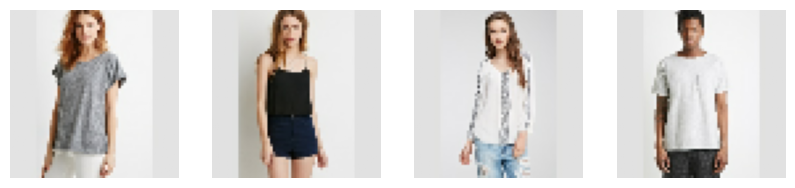

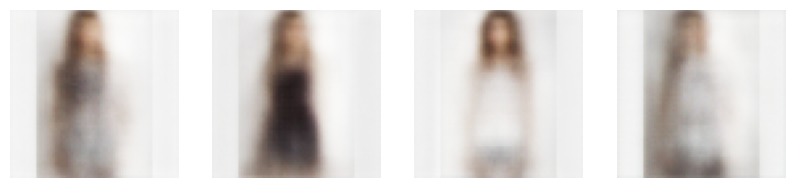

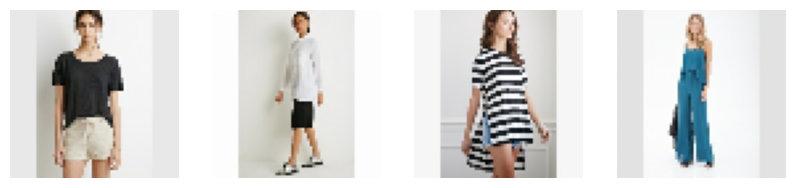

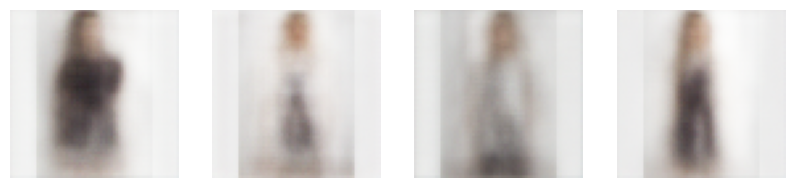

In [157]:
import matplotlib.pyplot as plt

def show(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(2):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)

In [158]:
def regenerate_image(image, new_color_id, new_binary_attributes):
    image = tf.expand_dims(image, axis=0)
    new_color_id = tf.expand_dims(new_color_id, axis=0)
    new_binary_attributes = tf.expand_dims(new_binary_attributes, axis=0)

    # Get color embeddings
    color_embeds = cvae.color_embedding(new_color_id)

    # Concatenate color embeddings with binary attributes
    attribute_vector = layers.Concatenate(axis=-1)([color_embeds, new_binary_attributes])

    # Encode input image and attributes
    z_mean, z_log_var = cvae.encoder([image, attribute_vector])

    # Sample from the latent space
    batch_size = tf.shape(image)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

    # Concatenate latent vector with the attribute vector
    z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])

    # Decode the conditioned latent vector
    regenerated_image = cvae.decoder(z_cond)

    return regenerated_image[0]

Cream-beige 


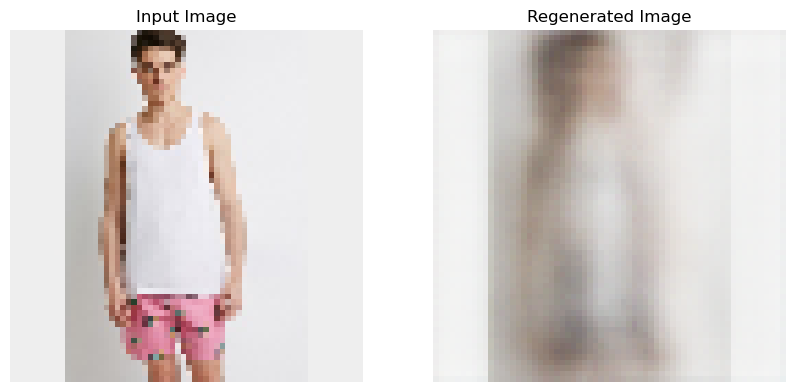

In [160]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

file = "data/img/id_00006150.jpg"
# Load the input image and preprocess it
input_image = cv2.imread(file)
input_image = cv2.resize(input_image, (64, 64))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = input_image / 255.0

# Define new color ID and binary attributes
new_color_id = 200  # Any integer value between 0 and 758 (num_colors - 1)
print(list(color_vocabulary.keys())[list(color_vocabulary.values()).index(new_color_id)])
#new_binary_attributes = np.random.randint(0, 2, size=(num_binary_attributes,)).astype(np.float32)
binary_attributes = item_attr_data[item_attr_data['img_idx']==file[9:-4]]
binary_attributes = binary_attributes.drop(columns=['index','img_idx','clothes_color'])

new_binary_attributes = binary_attributes.to_numpy(dtype=np.float32).flatten()
new_binary_attributes = (new_binary_attributes + 1) / 2


# Generate the new image
regenerated_image = regenerate_image(input_image, new_color_id, new_binary_attributes)

# Plot the input and regenerated images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(input_image)
ax1.set_title("Input Image")
ax1.axis("off")

ax2.imshow(regenerated_image)
ax2.set_title("Regenerated Image")
ax2.axis("off")

plt.show()

In [182]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np

# Load the InceptionV3 model
module_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
module = hub.KerasLayer(module_url, trainable=False)

# Define a function to preprocess the images
def preprocess(image):
    image = tf.image.resize(image, (299, 299)) / 255.0
    image = 2 * image - 1  # Normalize to [-1,1]
    return image

# Define a function to compute the activations of the InceptionV3 model for a batch of images
def get_activations(images):
    preprocessed_images = np.array([preprocess(image) for image in images])
    activations = module(preprocessed_images)
    return activations.numpy()

# Define a function to compute the FID score between two sets of images
def calculate_fid(images1, images2, batch_size=32):
    activations1 = get_activations(images1)
    activations2 = get_activations(images2)
    mean1 = np.mean(activations1, axis=0)
    mean2 = np.mean(activations2, axis=0)
    cov1 = np.cov(activations1, rowvar=False)
    cov2 = np.cov(activations2, rowvar=False)
    diff = mean1 - mean2
    covmean = tf.linalg.sqrtm(cov1.dot(cov2)).numpy()
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * np.trace(covmean)
    return fid

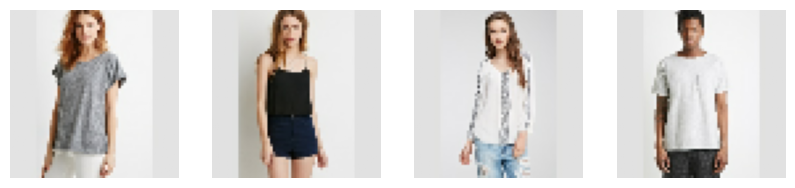

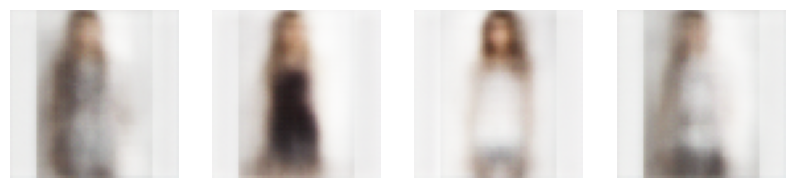

FID score: nan


In [183]:
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(1):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)
    fid = calculate_fid(batch_images, reconstructed_images)
    print("FID score:", fid)
